In [4]:
import numpy
import matplotlib
import torch

In [5]:
torch.cuda.is_available()

True

In [3]:
!nvidia-smi


Sat Dec 17 09:26:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.37       Driver Version: 527.37       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:27:00.0  On |                  N/A |
|  0%   46C    P5    19W / 125W |    960MiB /  6144MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import random

learning_rate = 0.001
batch_size = 10
epochs = 10

#устанавливаем зерно и случайное значение
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)


print(device)

cuda


Task 1-2

In [7]:
train_path = 'D:\Git\pyLab5_3sem\\train'
test_path = 'D:\Git\pyLab5_3sem\\test'
val_path = 'D:\Git\pyLab5_3sem\\val'

path1 = "dataset/zebra/zebra_annotation.csv"
path2 = "dataset/bay horse/bay horse_annotation.csv"
dfs = []
tmp = pd.read_csv(path1, sep=',', header=None)
dfs.append(tmp)
tmp = pd.read_csv(path2, sep=',', header=None)
dfs.append(tmp)
df = pd.concat(dfs)
df.drop(1, axis=1, inplace=True)
df.rename(columns={0: 'absolute_way', 2: 'class_img'}, inplace=True)
df.reset_index(inplace=True)


if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)


def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    '''
    dowload img from dataframe with path
    '''
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.class_img[i]}.{i}.jpg'), image)


def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    '''
    dowload img from dataframe with path, work with separation 80:10:10
    '''
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    if i - 840 > 104:
        i = i - 1785
    else:
        i = i - 840
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)


# using
for i in range(840):
    load_train(df, train_path, i)
    
for i in range(840, 945):
    load_test(df, test_path, i)

for i in range(945, 1050):
    load_train(df, val_path, i)

for i in range(1050, 1890):
    load_train(df, train_path, i)

for i in range(1890, 1995):
    load_test(df, test_path, i)

for i in range(1995, 2100):
    load_train(df, val_path, i)


train_list = glob.glob(os.path.join(train_path, '*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))

# split our data into train and test sets
train_list, val_list = train_test_split(train_list, test_size=0.1)


Check dataframe

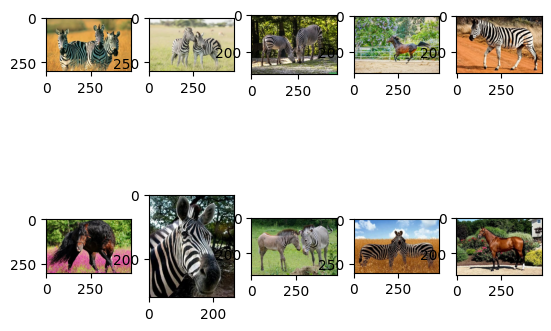

In [8]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

Task 3, convolutional neural network

In [9]:
# from tutorial
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = ConvNet().to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


task 4, preprocessing data

In [10]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

preprocessing

In [11]:
from PIL import Image

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'bay horse':
            label = 1
        elif label == 'zebra':
            label = 0
            
        return img_transformed,label


train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

Task 5-6, training

Learning rate: 0.001, Batch size: 10
Epoch : 1, train accuracy : 0.8388158082962036, train loss : 0.3448455333709717
Epoch : 1, val_accuracy : 0.8529412150382996, val_loss : 0.2604109048843384
Epoch : 2, train accuracy : 0.8940787315368652, train loss : 0.24149587750434875
Epoch : 2, val_accuracy : 0.9205883145332336, val_loss : 0.20381765067577362
Epoch : 3, train accuracy : 0.9111836552619934, train loss : 0.21704451739788055
Epoch : 3, val_accuracy : 0.9411764740943909, val_loss : 0.1397327333688736
Epoch : 4, train accuracy : 0.9335523843765259, train loss : 0.18160639703273773
Epoch : 4, val_accuracy : 0.9279412627220154, val_loss : 0.16145002841949463
Epoch : 5, train accuracy : 0.9309208393096924, train loss : 0.17851966619491577
Epoch : 5, val_accuracy : 0.947058916091919, val_loss : 0.10770809650421143
Epoch : 6, train accuracy : 0.9296050071716309, train loss : 0.17956268787384033
Epoch : 6, val_accuracy : 0.9191176891326904, val_loss : 0.18596318364143372
Epoch : 7, train ac

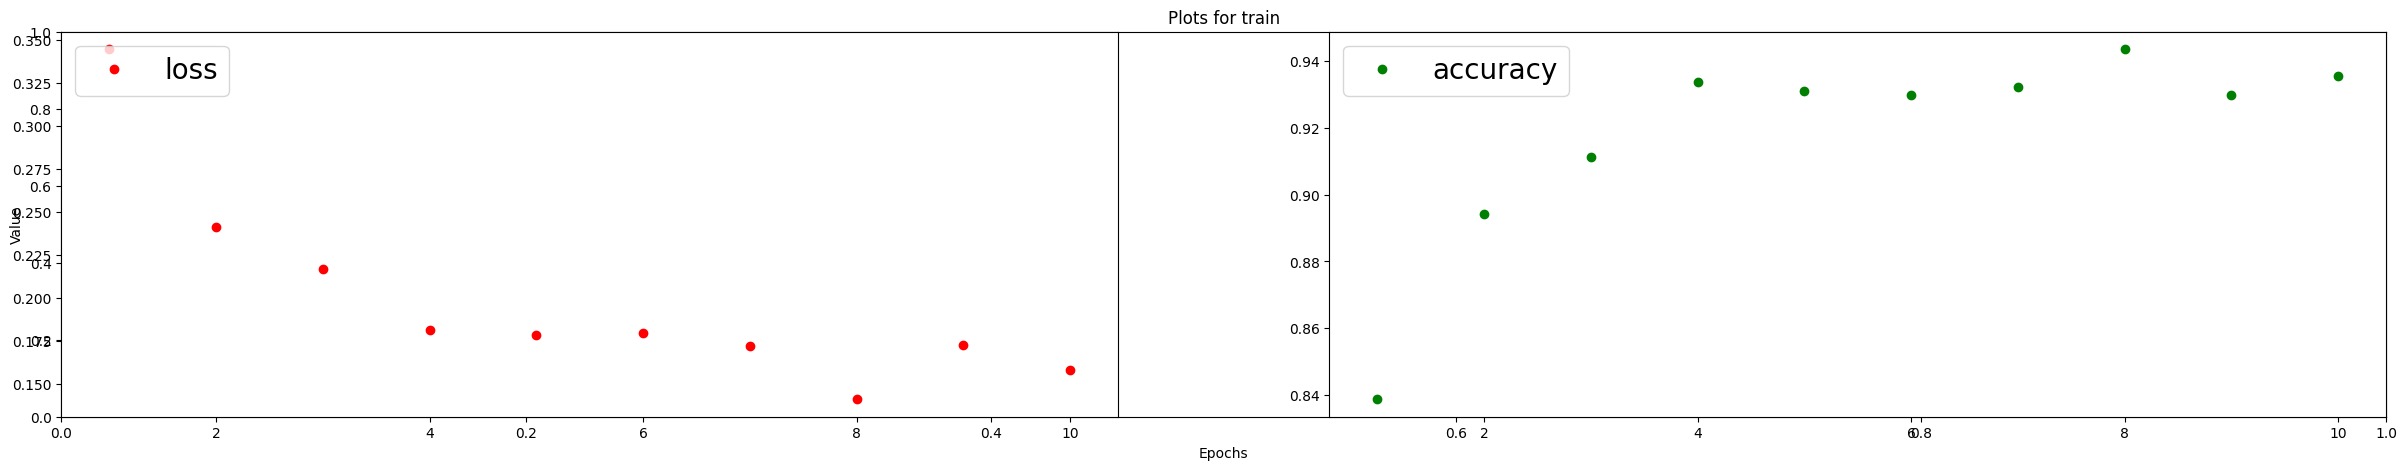

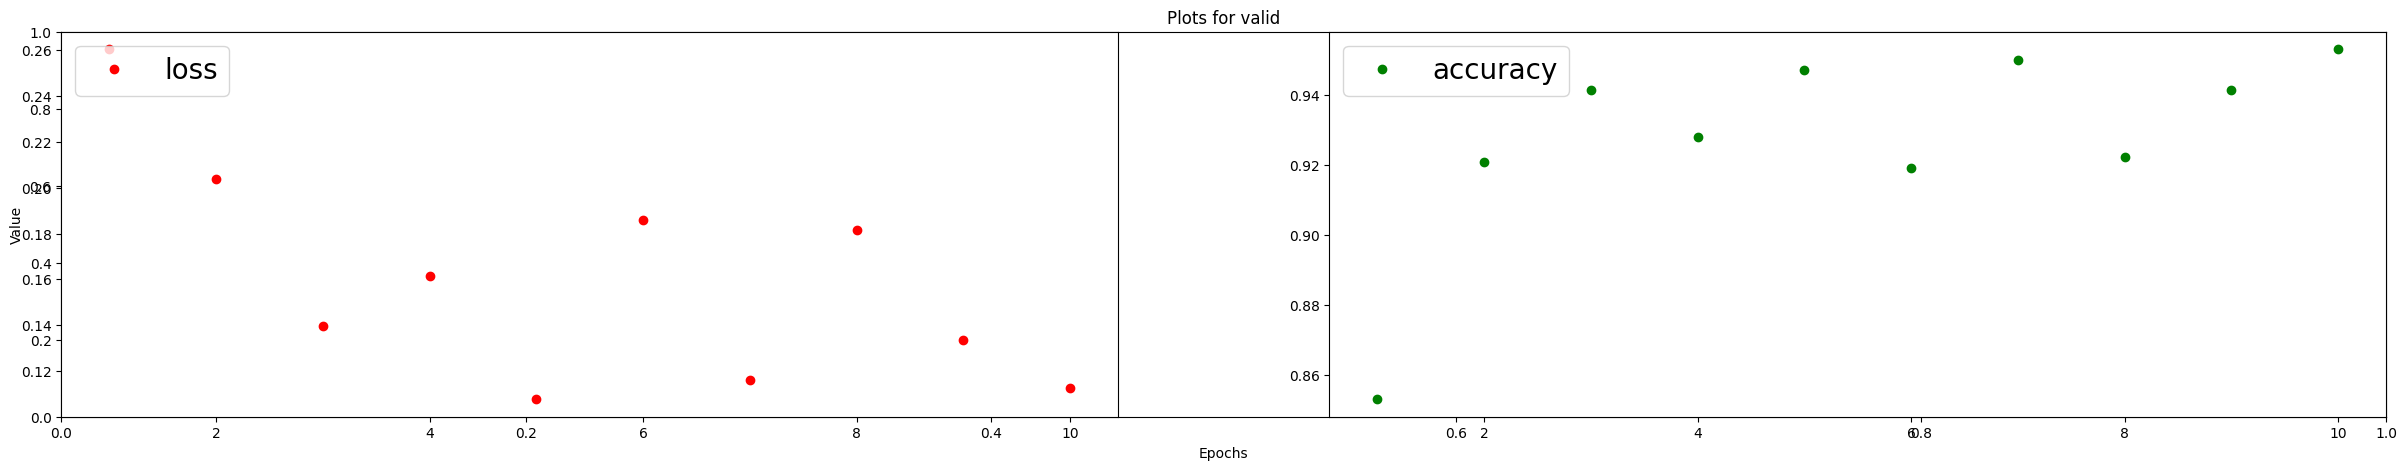

In [12]:
print('Learning rate: 0.001, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

epochs = 10
def train_loop (train_loader, val_loader, epochs):
    val_loss_list = []
    val_accuracy_list = []

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        
        
        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0

            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)

            
            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
    

    num_epochs = [i+1 for i in range(epochs)]

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20}) 
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20}) 

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for valid')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, val_loss_list, 'ro', label = 'loss')
    plt.legend(loc=2, prop={'size': 20}) 
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, val_accuracy_list, 'go', label = 'accuracy')
    plt.legend(loc=2, prop={'size': 20}) 

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 10
Epoch : 1, train accuracy : 0.9414469599723816, train loss : 0.13397030532360077
Epoch : 1, val_accuracy : 0.9529412984848022, val_loss : 0.11843369901180267
Epoch : 2, train accuracy : 0.9447364807128906, train loss : 0.1370972990989685
Epoch : 2, val_accuracy : 0.9529412984848022, val_loss : 0.12320604920387268
Epoch : 3, train accuracy : 0.9473675489425659, train loss : 0.13797160983085632
Epoch : 3, val_accuracy : 0.9117647409439087, val_loss : 0.18232905864715576
Epoch : 4, train accuracy : 0.9493415951728821, train loss : 0.12215471267700195
Epoch : 4, val_accuracy : 0.9691176414489746, val_loss : 0.09499046206474304
Epoch : 5, train accuracy : 0.9552624225616455, train loss : 0.1091780886054039
Epoch : 5, val_accuracy : 0.958823561668396, val_loss : 0.10486885905265808
Epoch : 6, train accuracy : 0.9592097997665405, train loss : 0.11107371747493744
Epoch : 6, val_accuracy : 0.9529411792755127, val_loss : 0.12786909937858582
Epoch : 7, train 

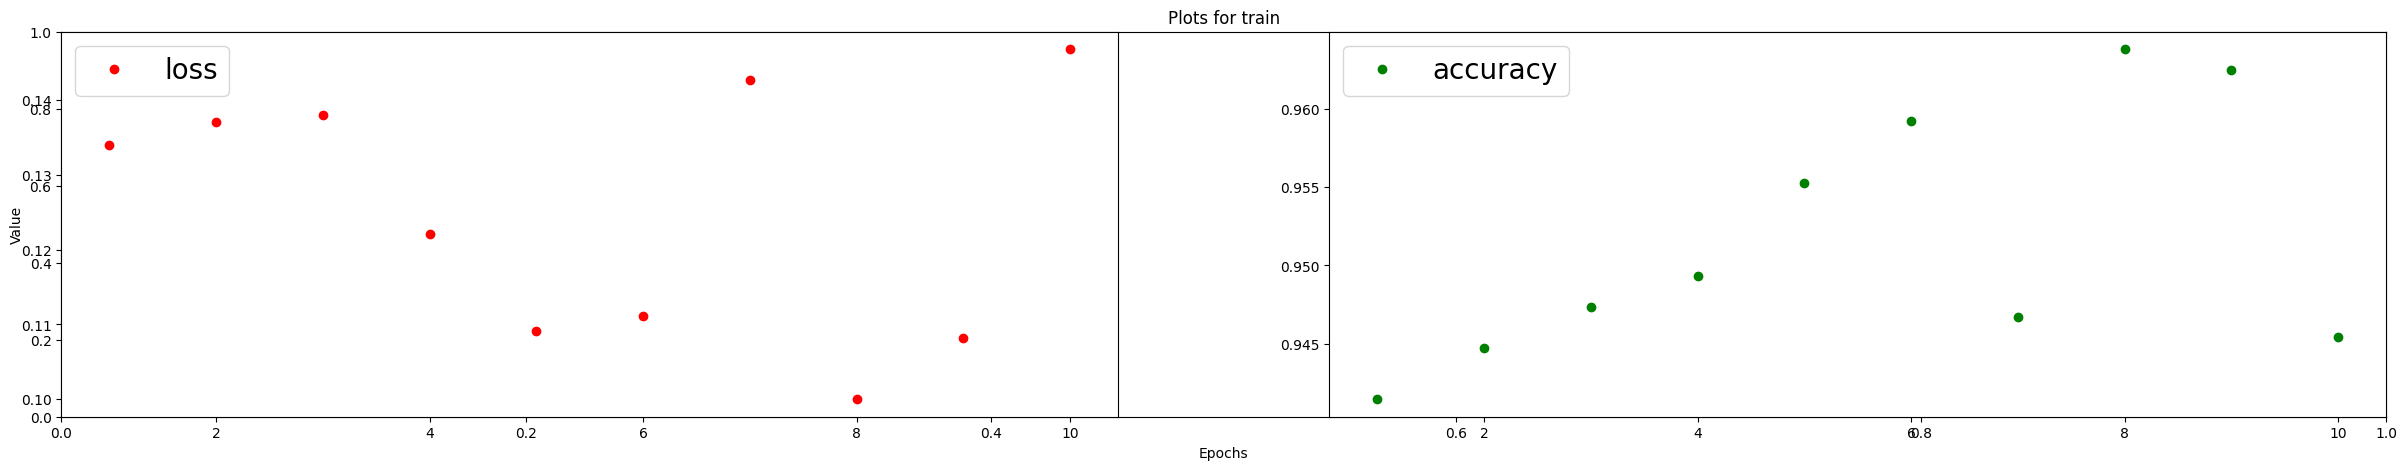

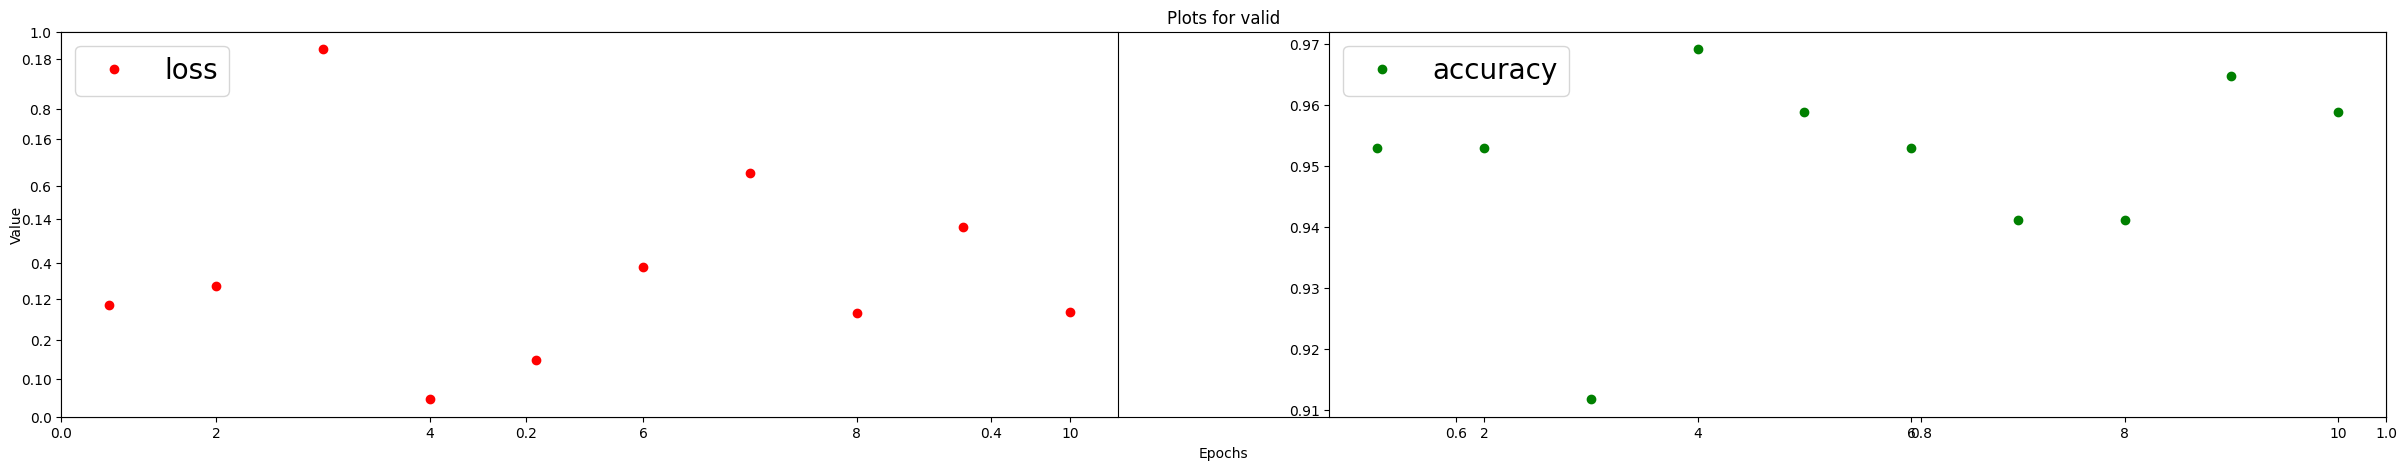

In [13]:
print('Learning rate: 0.0005, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 10
Epoch : 1, train accuracy : 0.9565781950950623, train loss : 0.11192548274993896
Epoch : 1, val_accuracy : 0.9705882668495178, val_loss : 0.10071945935487747
Epoch : 2, train accuracy : 0.9546043872833252, train loss : 0.11934744566679001
Epoch : 2, val_accuracy : 0.9750000238418579, val_loss : 0.06398998945951462
Epoch : 3, train accuracy : 0.9453941583633423, train loss : 0.142570361495018
Epoch : 3, val_accuracy : 0.9705882668495178, val_loss : 0.14321903884410858
Epoch : 4, train accuracy : 0.9421047568321228, train loss : 0.13462942838668823
Epoch : 4, val_accuracy : 0.9705882668495178, val_loss : 0.08191066980361938
Epoch : 5, train accuracy : 0.958551824092865, train loss : 0.10265600681304932
Epoch : 5, val_accuracy : 0.9529412388801575, val_loss : 0.12644951045513153
Epoch : 6, train accuracy : 0.9611834287643433, train loss : 0.09342589974403381
Epoch : 6, val_accuracy : 0.9529411792755127, val_loss : 0.11390750855207443
Epoch : 7, train 

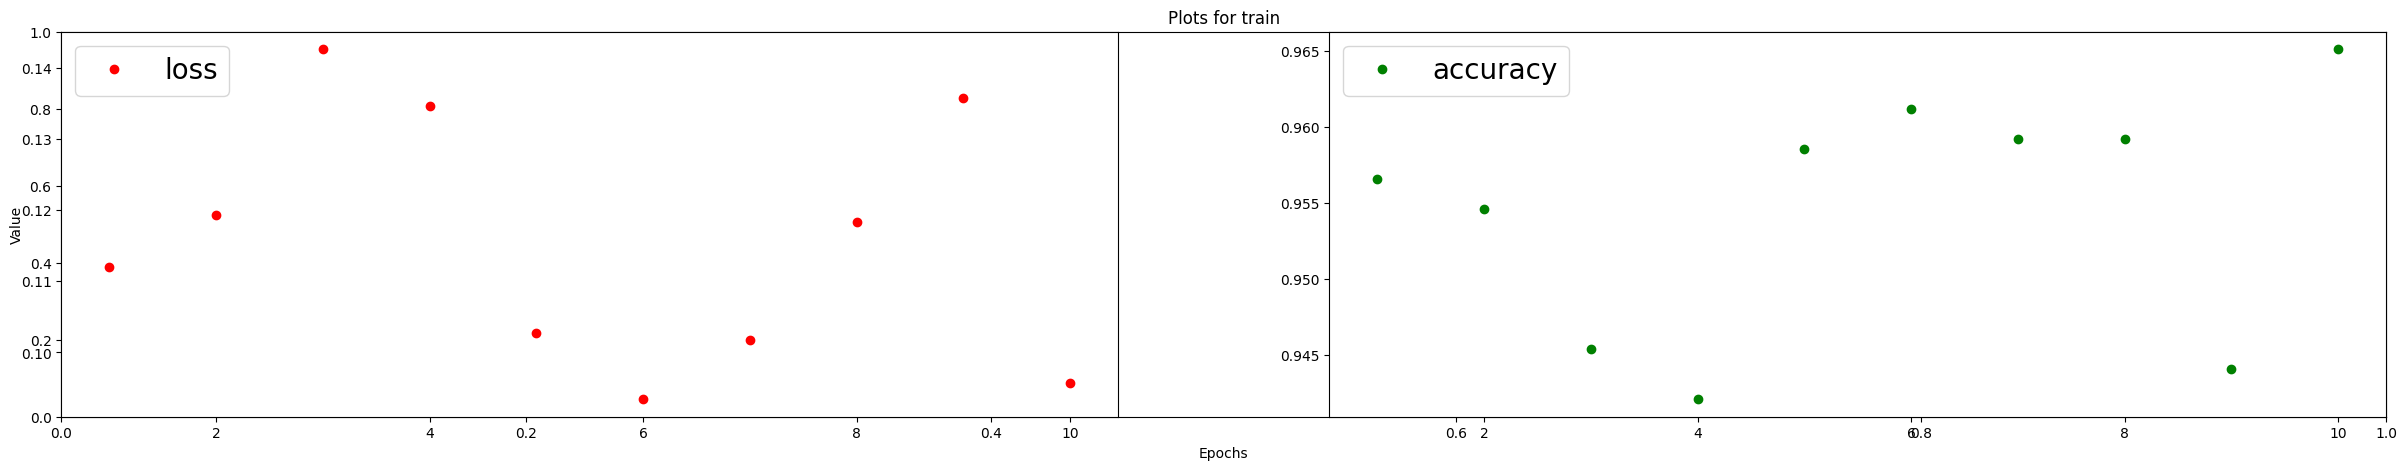

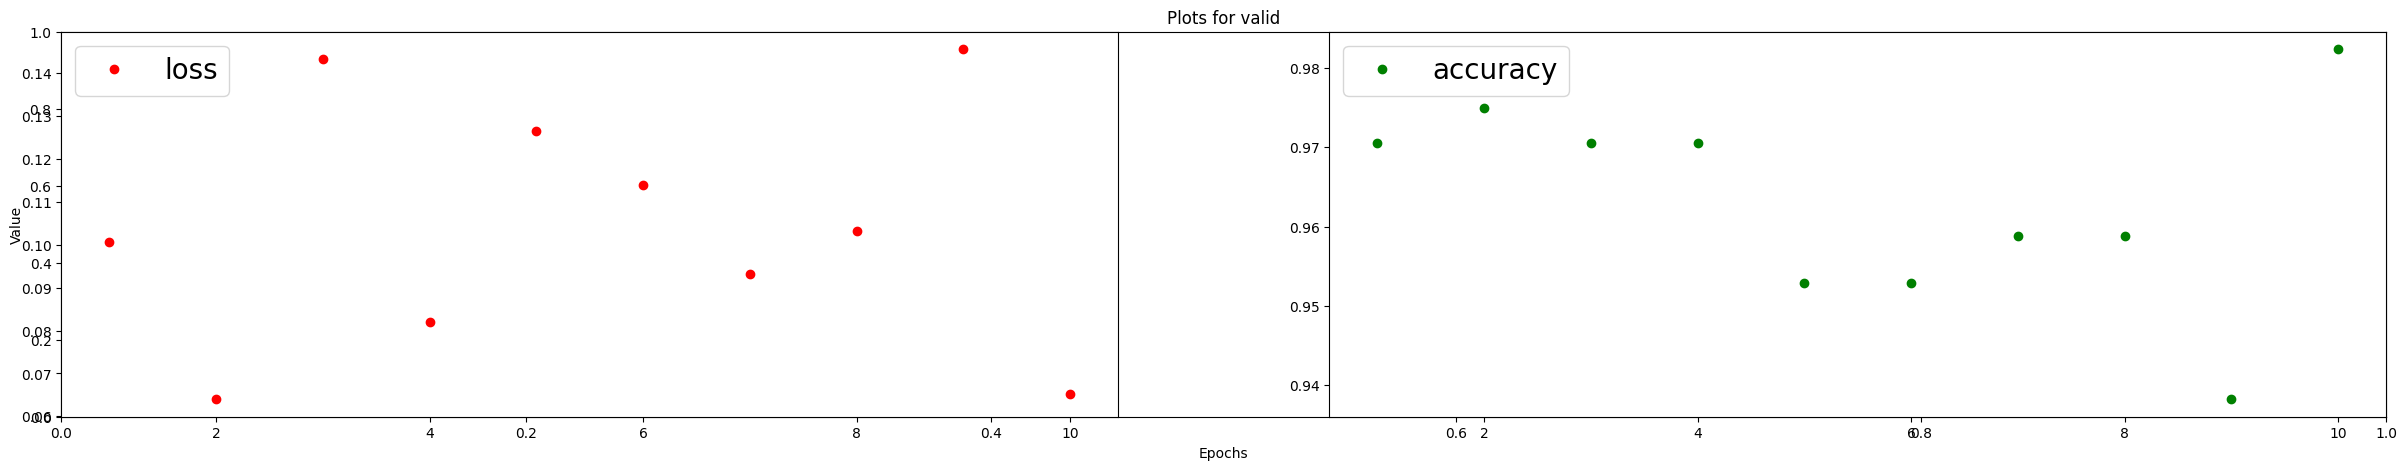

In [14]:
print('Learning rate: 0.0007, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 20
Epoch : 1, train accuracy : 0.9664475321769714, train loss : 0.08534616231918335
Epoch : 1, val_accuracy : 0.9666666388511658, val_loss : 0.09052357077598572
Epoch : 2, train accuracy : 0.9701755046844482, train loss : 0.0826149433851242
Epoch : 2, val_accuracy : 0.9833332896232605, val_loss : 0.07435651868581772
Epoch : 3, train accuracy : 0.9664475321769714, train loss : 0.08163029700517654
Epoch : 3, val_accuracy : 0.9777777791023254, val_loss : 0.07189296931028366
Epoch : 4, train accuracy : 0.9673246741294861, train loss : 0.07940192520618439
Epoch : 4, val_accuracy : 0.9611111283302307, val_loss : 0.06550677865743637
Epoch : 5, train accuracy : 0.9673247933387756, train loss : 0.0815213993191719
Epoch : 5, val_accuracy : 0.9777777194976807, val_loss : 0.06663806736469269
Epoch : 6, train accuracy : 0.9660087823867798, train loss : 0.09449987858533859
Epoch : 6, val_accuracy : 0.9833332896232605, val_loss : 0.048875726759433746
Epoch : 7, train

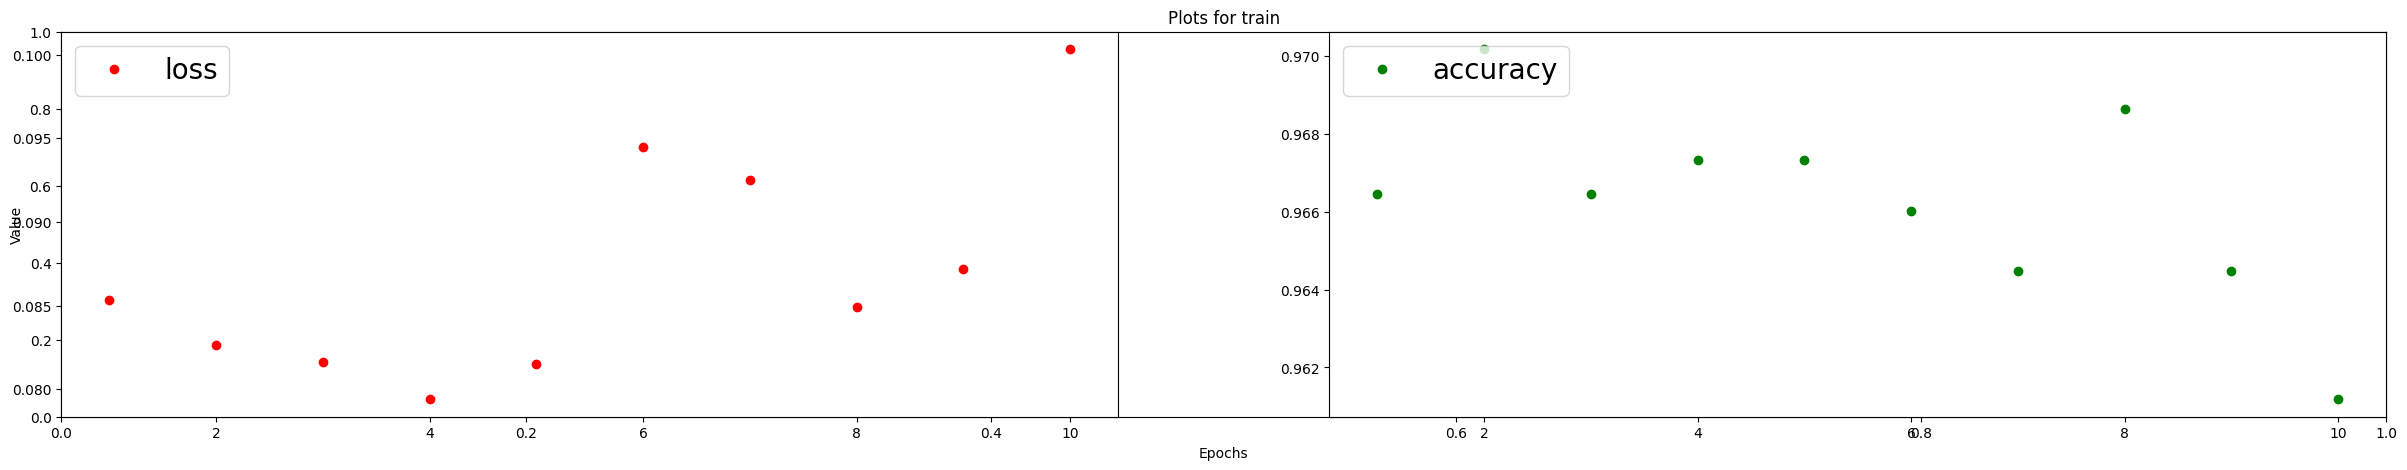

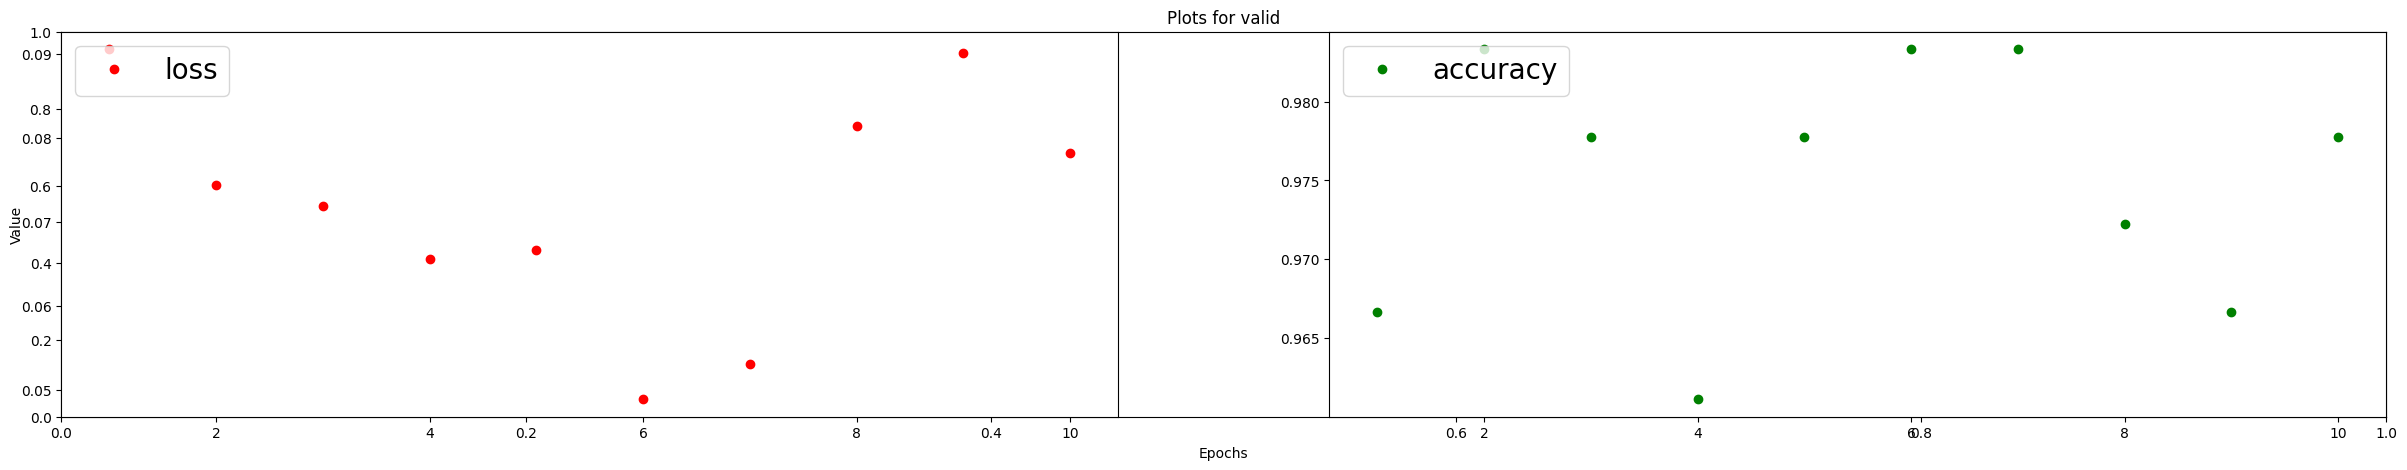

In [15]:
print('Learning rate: 0.001, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 20
Epoch : 1, train accuracy : 0.9723685383796692, train loss : 0.07073777914047241
Epoch : 1, val_accuracy : 0.9888888597488403, val_loss : 0.049924585968256
Epoch : 2, train accuracy : 0.9719299674034119, train loss : 0.06869008392095566
Epoch : 2, val_accuracy : 0.9833332896232605, val_loss : 0.05709510296583176
Epoch : 3, train accuracy : 0.9756579995155334, train loss : 0.062005992978811264
Epoch : 3, val_accuracy : 0.9833332896232605, val_loss : 0.055279918015003204
Epoch : 4, train accuracy : 0.9802632927894592, train loss : 0.05375109612941742
Epoch : 4, val_accuracy : 0.9694443941116333, val_loss : 0.10811422765254974
Epoch : 5, train accuracy : 0.9776318073272705, train loss : 0.055097125470638275
Epoch : 5, val_accuracy : 0.9583332538604736, val_loss : 0.08671943843364716
Epoch : 6, train accuracy : 0.9763159155845642, train loss : 0.0588381290435791
Epoch : 6, val_accuracy : 0.9777777194976807, val_loss : 0.04726957529783249
Epoch : 7, tra

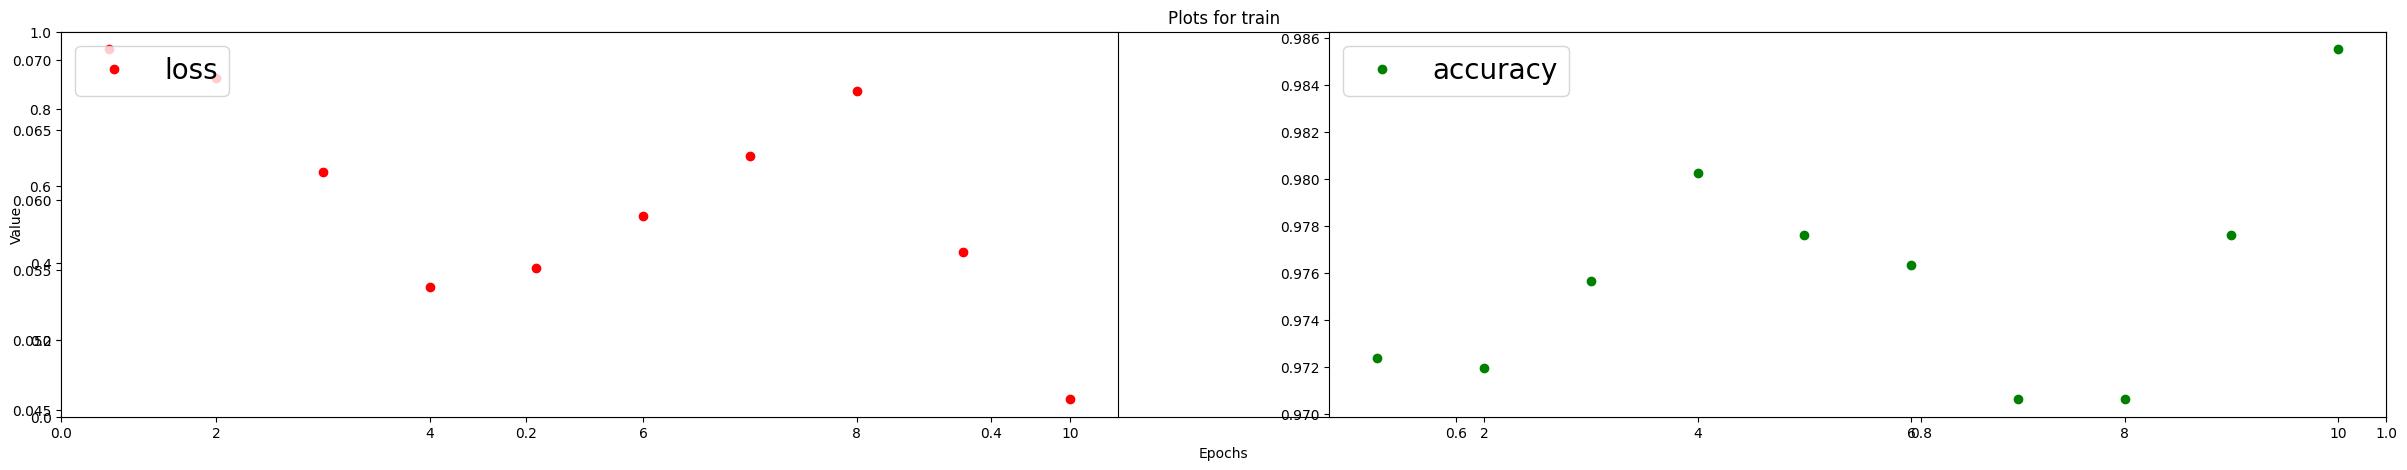

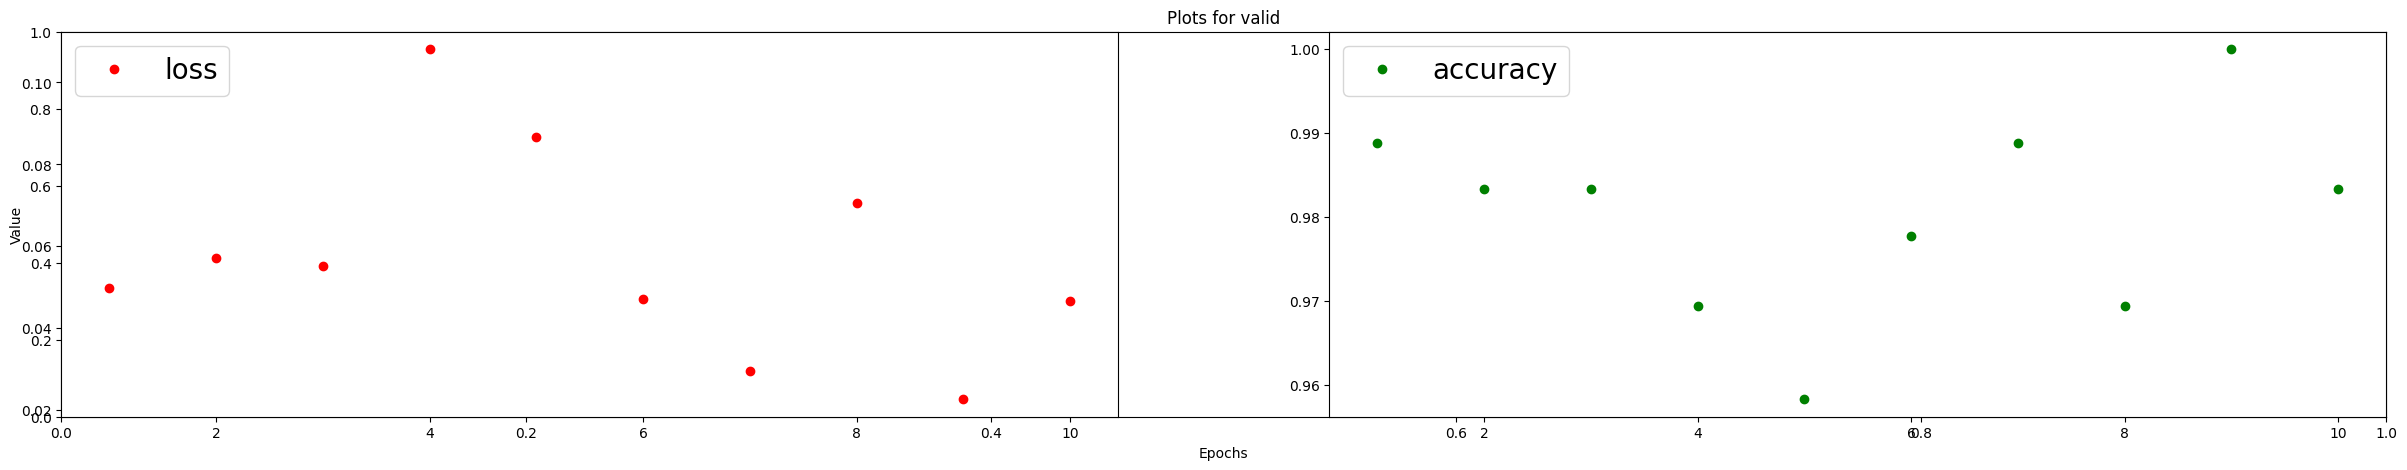

In [16]:
print('Learning rate: 0.0005, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 20
Epoch : 1, train accuracy : 0.9765353202819824, train loss : 0.06012941151857376
Epoch : 1, val_accuracy : 0.9666666388511658, val_loss : 0.08061739057302475
Epoch : 2, train accuracy : 0.9782895445823669, train loss : 0.05750012770295143
Epoch : 2, val_accuracy : 0.9722222089767456, val_loss : 0.0623345673084259
Epoch : 3, train accuracy : 0.9782896637916565, train loss : 0.051614515483379364
Epoch : 3, val_accuracy : 0.9888888597488403, val_loss : 0.027449198067188263
Epoch : 4, train accuracy : 0.9756582379341125, train loss : 0.05121796950697899
Epoch : 4, val_accuracy : 0.9777777791023254, val_loss : 0.05554512143135071
Epoch : 5, train accuracy : 0.9736842513084412, train loss : 0.07015105336904526
Epoch : 5, val_accuracy : 0.9833332896232605, val_loss : 0.035337962210178375
Epoch : 6, train accuracy : 0.9745615720748901, train loss : 0.06230528652667999
Epoch : 6, val_accuracy : 0.9777777791023254, val_loss : 0.07358536869287491
Epoch : 7, t

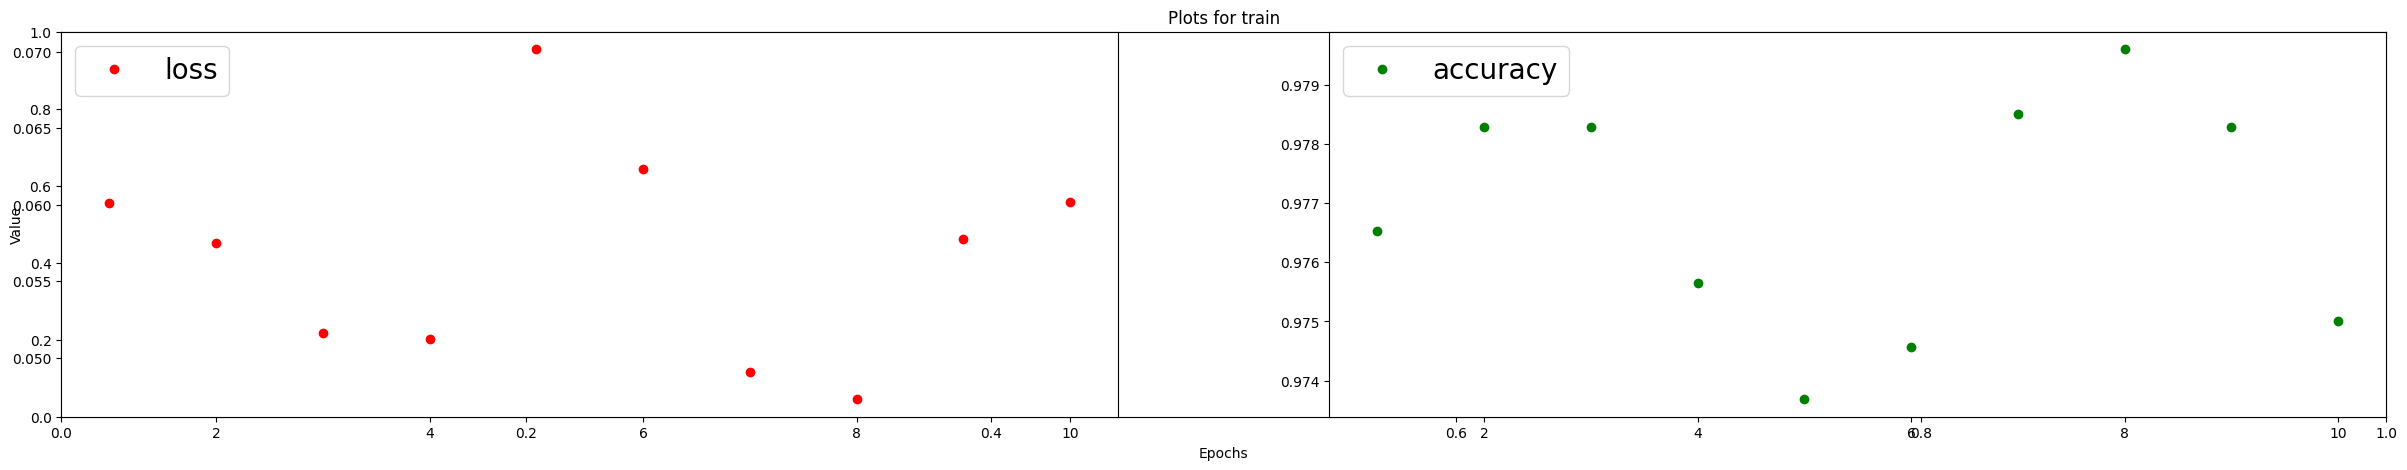

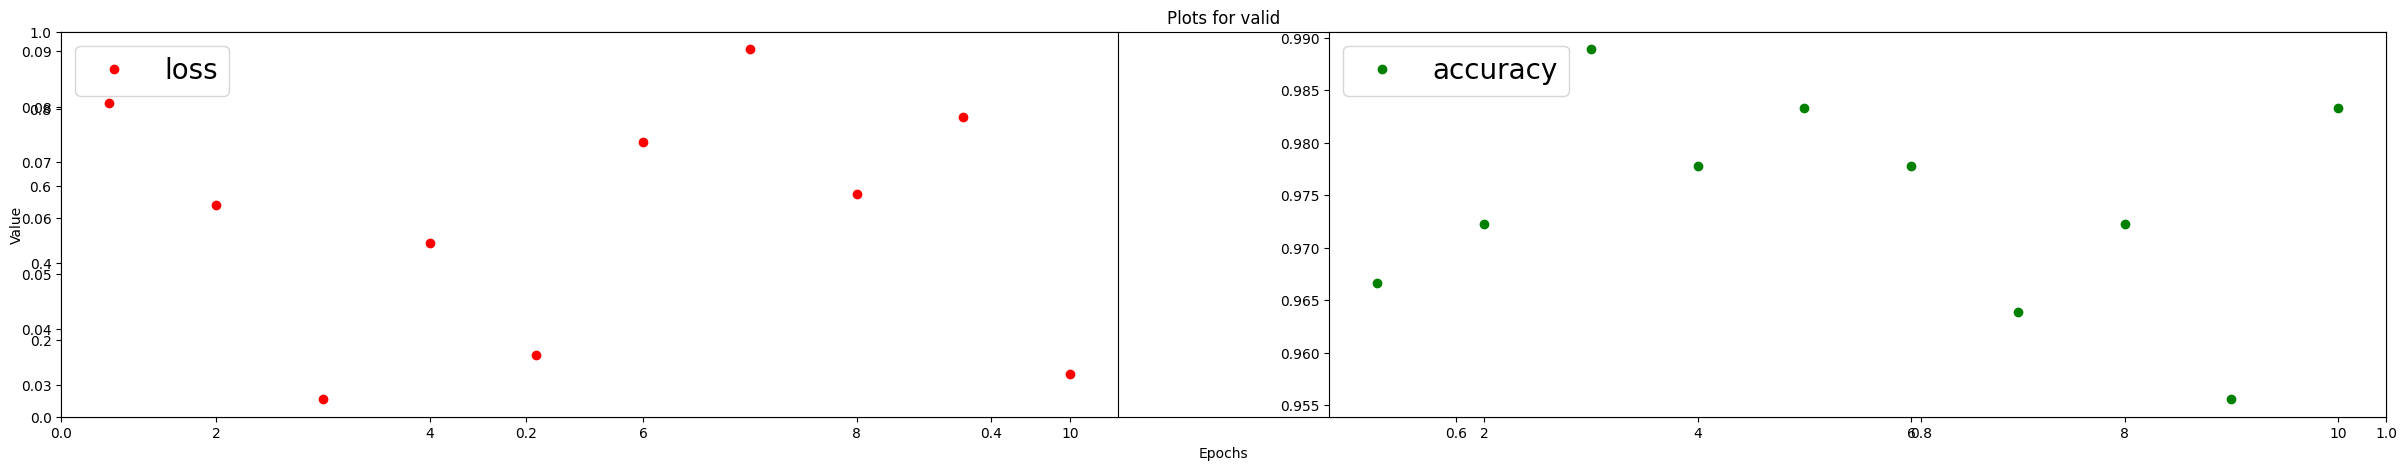

In [17]:
print('Learning rate: 0.0007, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 20
Epoch : 1, train accuracy : 0.9842107892036438, train loss : 0.05176432058215141
Epoch : 1, val_accuracy : 0.9861111044883728, val_loss : 0.03271351754665375
Epoch : 2, train accuracy : 0.983552873134613, train loss : 0.043605782091617584
Epoch : 2, val_accuracy : 0.9666666388511658, val_loss : 0.0606522336602211
Epoch : 3, train accuracy : 0.9723686575889587, train loss : 0.06108330190181732
Epoch : 3, val_accuracy : 0.9888888597488403, val_loss : 0.039075665175914764
Epoch : 4, train accuracy : 0.984210729598999, train loss : 0.03379957750439644
Epoch : 4, val_accuracy : 0.9777777791023254, val_loss : 0.04400133341550827
Epoch : 5, train accuracy : 0.9745615720748901, train loss : 0.0570177361369133
Epoch : 5, val_accuracy : 0.9749999642372131, val_loss : 0.06337900459766388
Epoch : 6, train accuracy : 0.9750000834465027, train loss : 0.06152996048331261
Epoch : 6, val_accuracy : 0.9888888597488403, val_loss : 0.03944152221083641
Epoch : 7, train

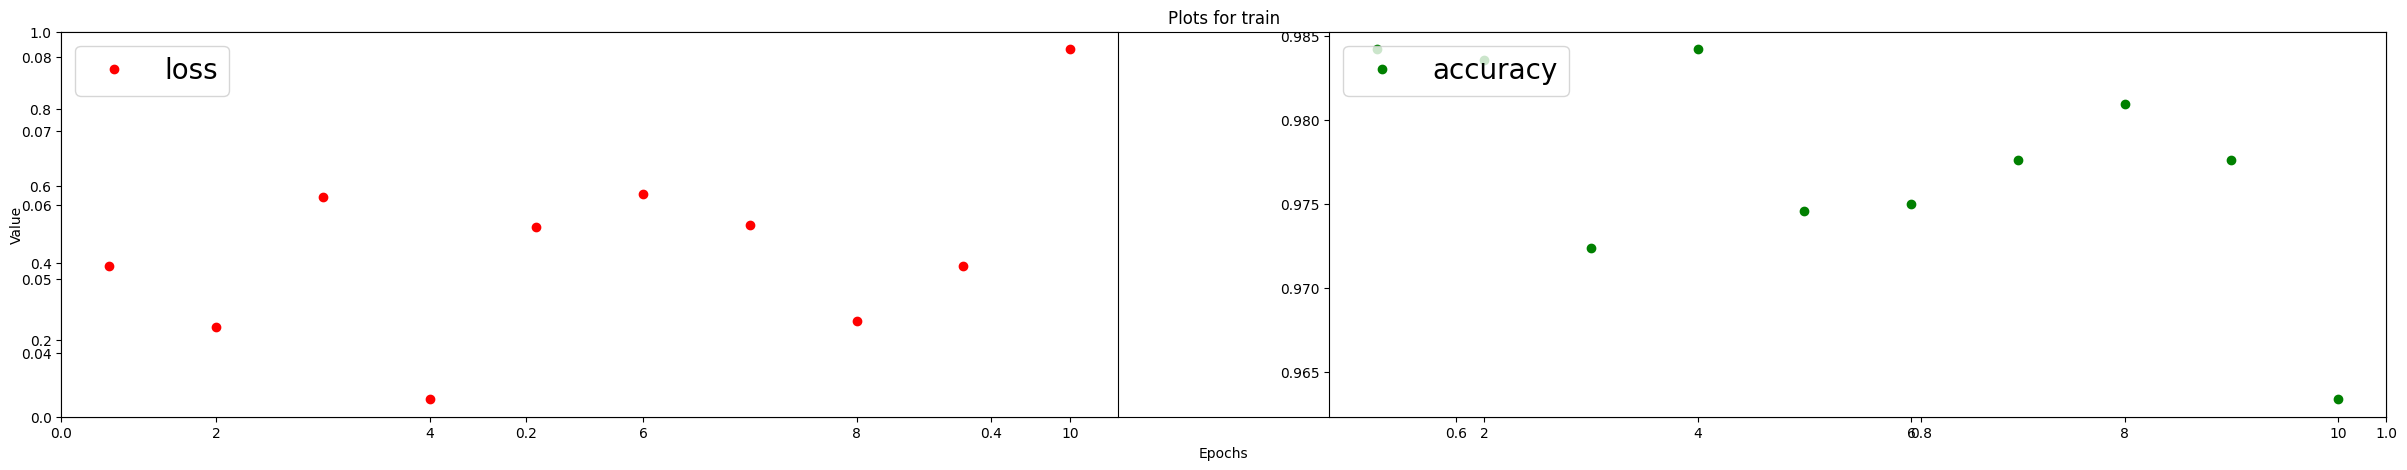

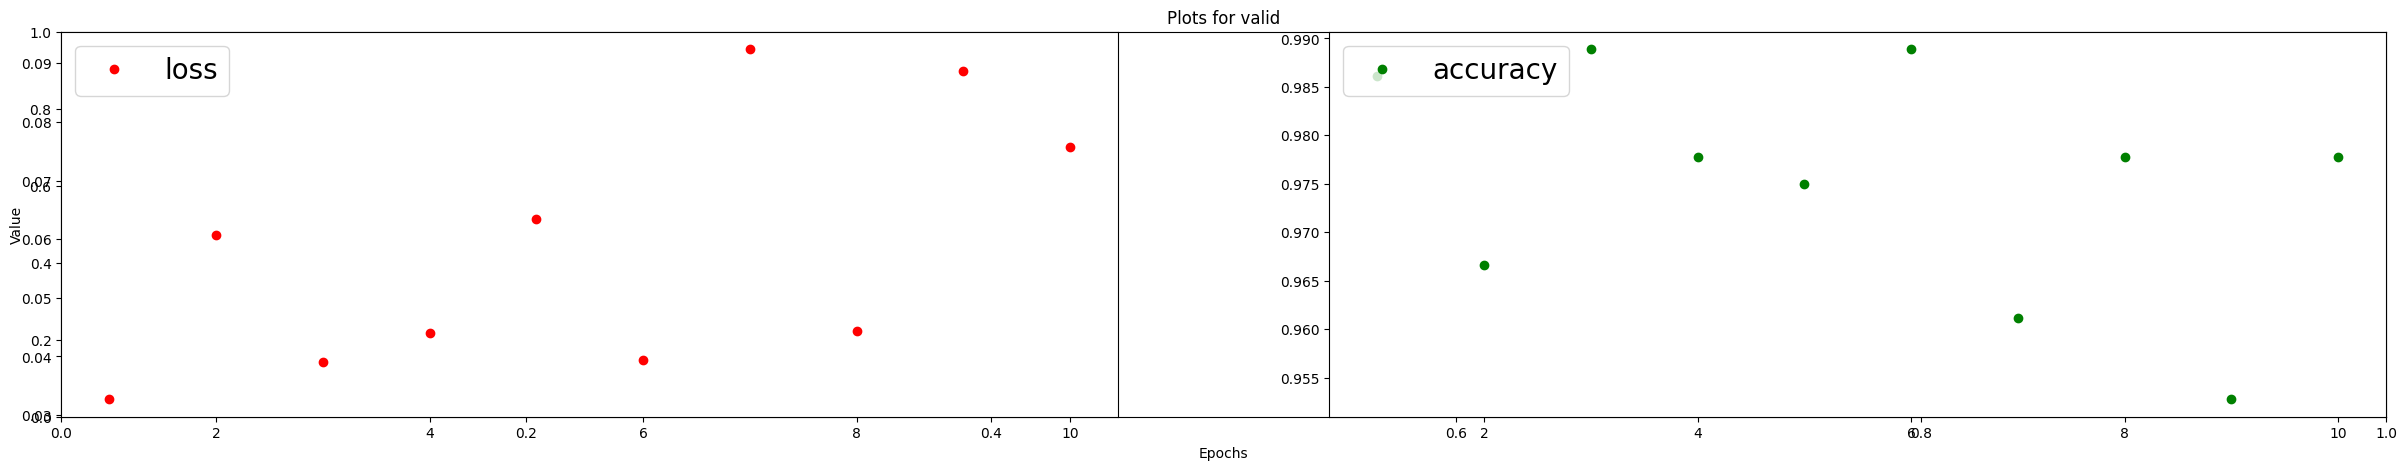

In [25]:
print('Learning rate: 0.0007, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 20
Epoch : 1, train accuracy : 0.9809213280677795, train loss : 0.052604783326387405
Epoch : 1, val_accuracy : 0.9722222089767456, val_loss : 0.05473029240965843
Epoch : 2, train accuracy : 0.9782896637916565, train loss : 0.0454900823533535
Epoch : 2, val_accuracy : 0.9722221493721008, val_loss : 0.06398479640483856
Epoch : 3, train accuracy : 0.975000262260437, train loss : 0.05874374136328697
Epoch : 3, val_accuracy : 0.9888888597488403, val_loss : 0.05705567076802254
Epoch : 4, train accuracy : 0.9809211492538452, train loss : 0.0537349134683609
Epoch : 4, val_accuracy : 0.9888888597488403, val_loss : 0.03120962157845497
Epoch : 5, train accuracy : 0.9811407923698425, train loss : 0.047093357890844345
Epoch : 5, val_accuracy : 0.9527777433395386, val_loss : 0.09684053808450699
Epoch : 6, train accuracy : 0.980263352394104, train loss : 0.04975458234548569
Epoch : 6, val_accuracy : 0.9944444298744202, val_loss : 0.02131003327667713
Epoch : 7, train

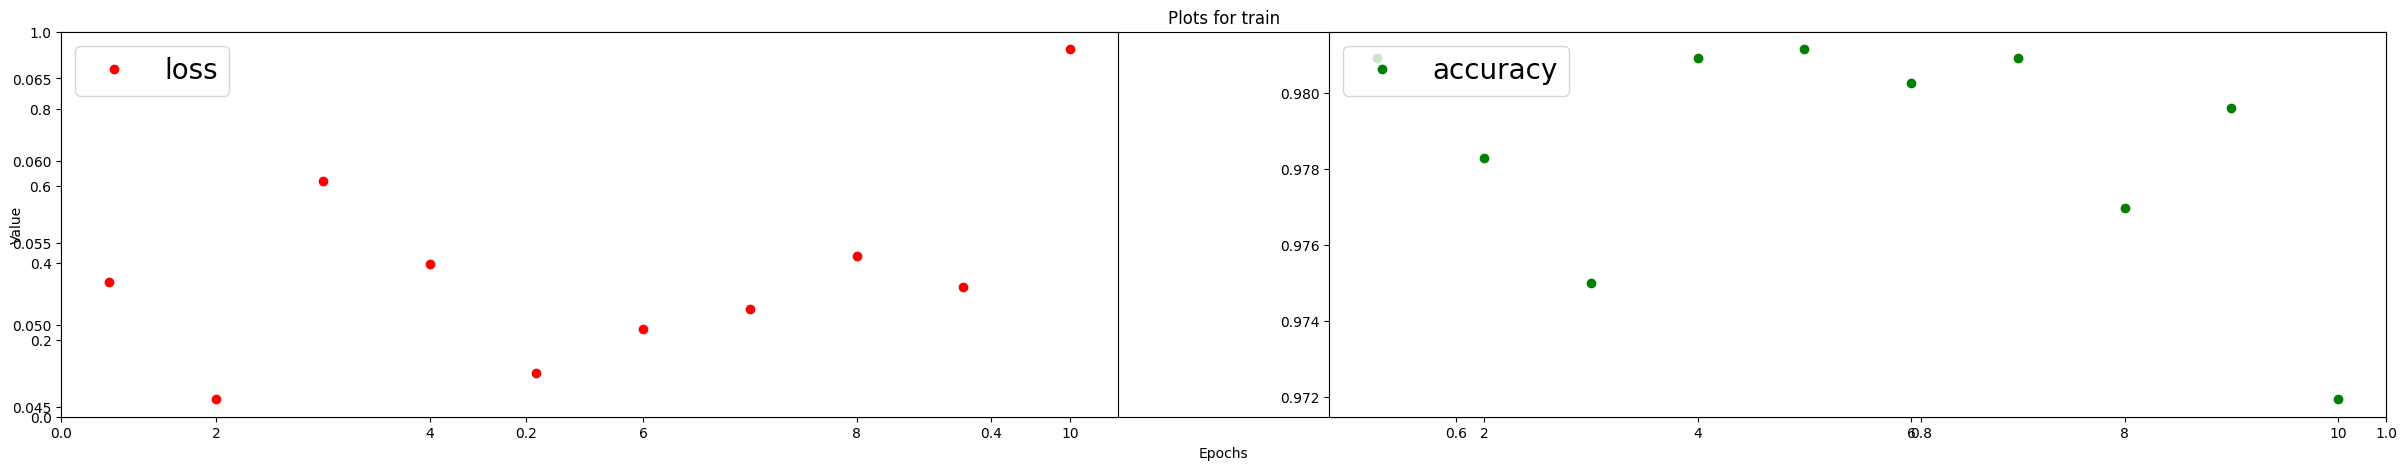

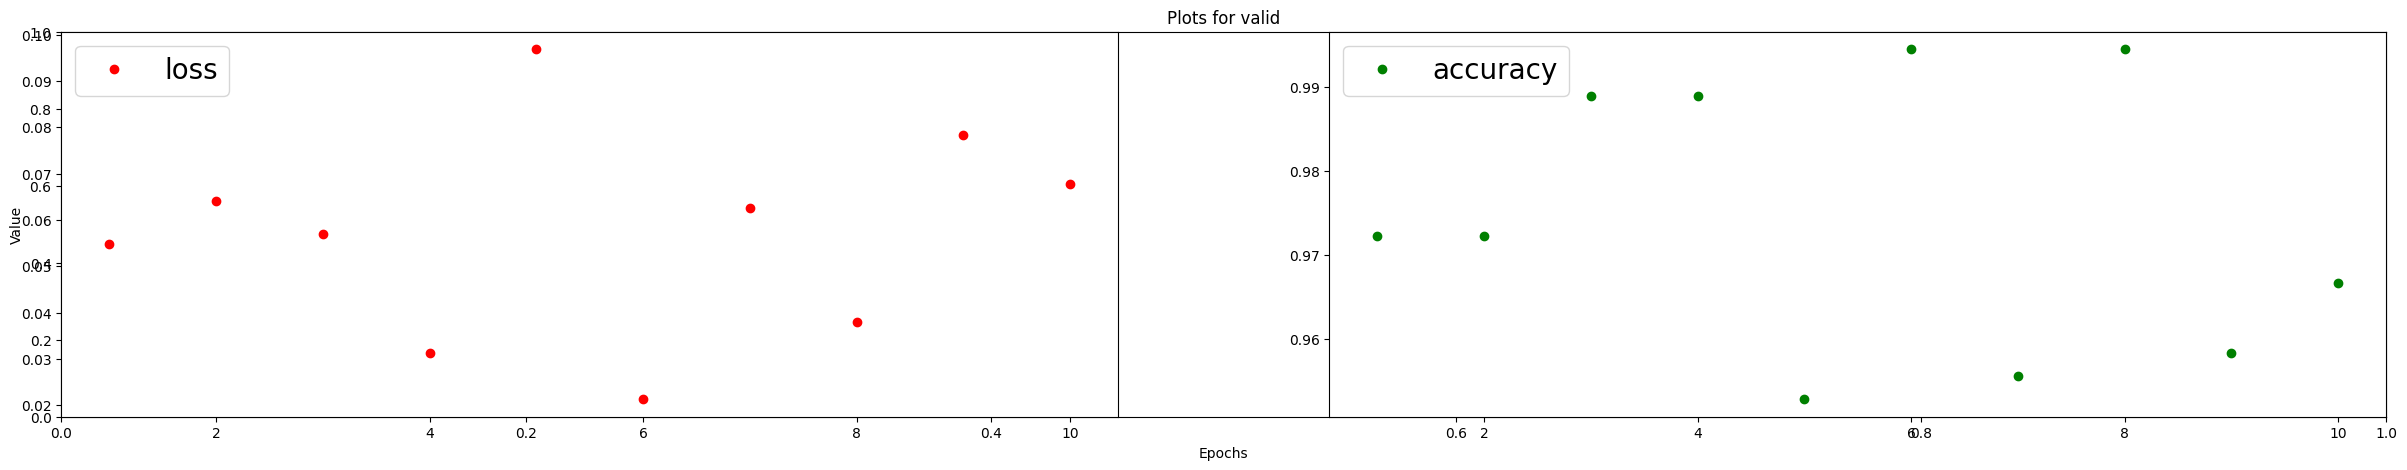

In [19]:
print('Learning rate: 0.0007, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 50
Epoch : 1, train accuracy : 0.9824726581573486, train loss : 0.049465205520391464
Epoch : 1, val_accuracy : 0.9472221732139587, val_loss : 0.07899004220962524
Epoch : 2, train accuracy : 0.9851608276367188, train loss : 0.03564951941370964
Epoch : 2, val_accuracy : 0.9850000143051147, val_loss : 0.059391818940639496
Epoch : 3, train accuracy : 0.9845156669616699, train loss : 0.03815804794430733
Epoch : 3, val_accuracy : 0.9950000047683716, val_loss : 0.029651222750544548
Epoch : 4, train accuracy : 0.9825801849365234, train loss : 0.045708246529102325
Epoch : 4, val_accuracy : 1.0, val_loss : 0.02615581452846527
Epoch : 5, train accuracy : 0.9863436222076416, train loss : 0.03143598139286041
Epoch : 5, val_accuracy : 0.98499995470047, val_loss : 0.036033354699611664
Epoch : 6, train accuracy : 0.9851608276367188, train loss : 0.03530766814947128
Epoch : 6, val_accuracy : 0.9900000095367432, val_loss : 0.019619770348072052
Epoch : 7, train accuracy

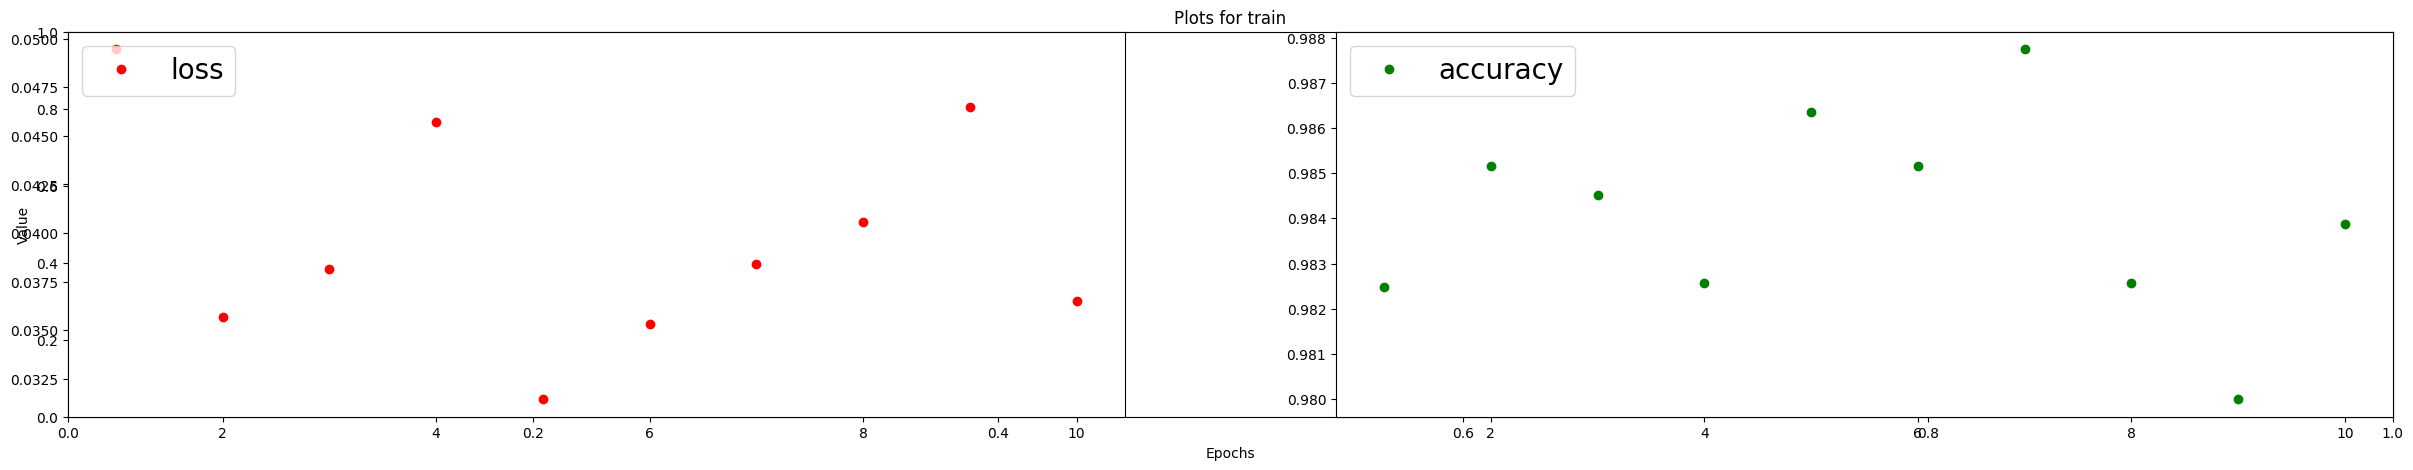

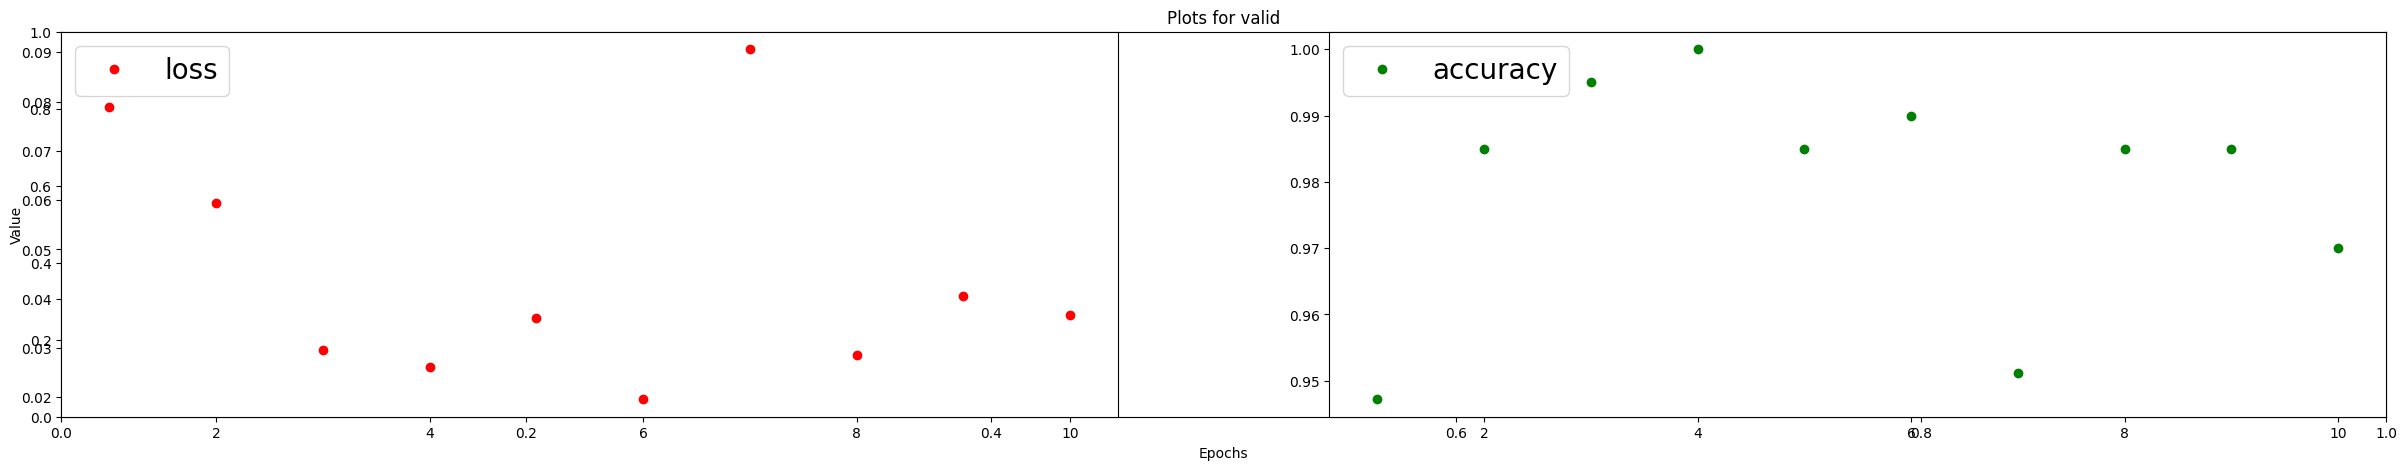

In [20]:
print('Learning rate: 0.0007, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

task 7-8, The work of the model

In [21]:
polarbears_probs = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        polarbears_probs += list(zip(labels, preds_list))
        
idx = list(map(lambda x: x[0],polarbears_probs))
prob = list(map(lambda x: x[1],polarbears_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

id         label
0    141  9.999764e-01
1     55  2.528171e-03
2    168  9.897804e-01
3    172  9.949052e-01
4     51  6.807547e-11
..   ...           ...
205  191  9.750783e-01
206  128  9.999998e-01
207  201  9.709262e-01
208   91  5.858251e-11
209  171  9.999563e-01

[210 rows x 2 columns]

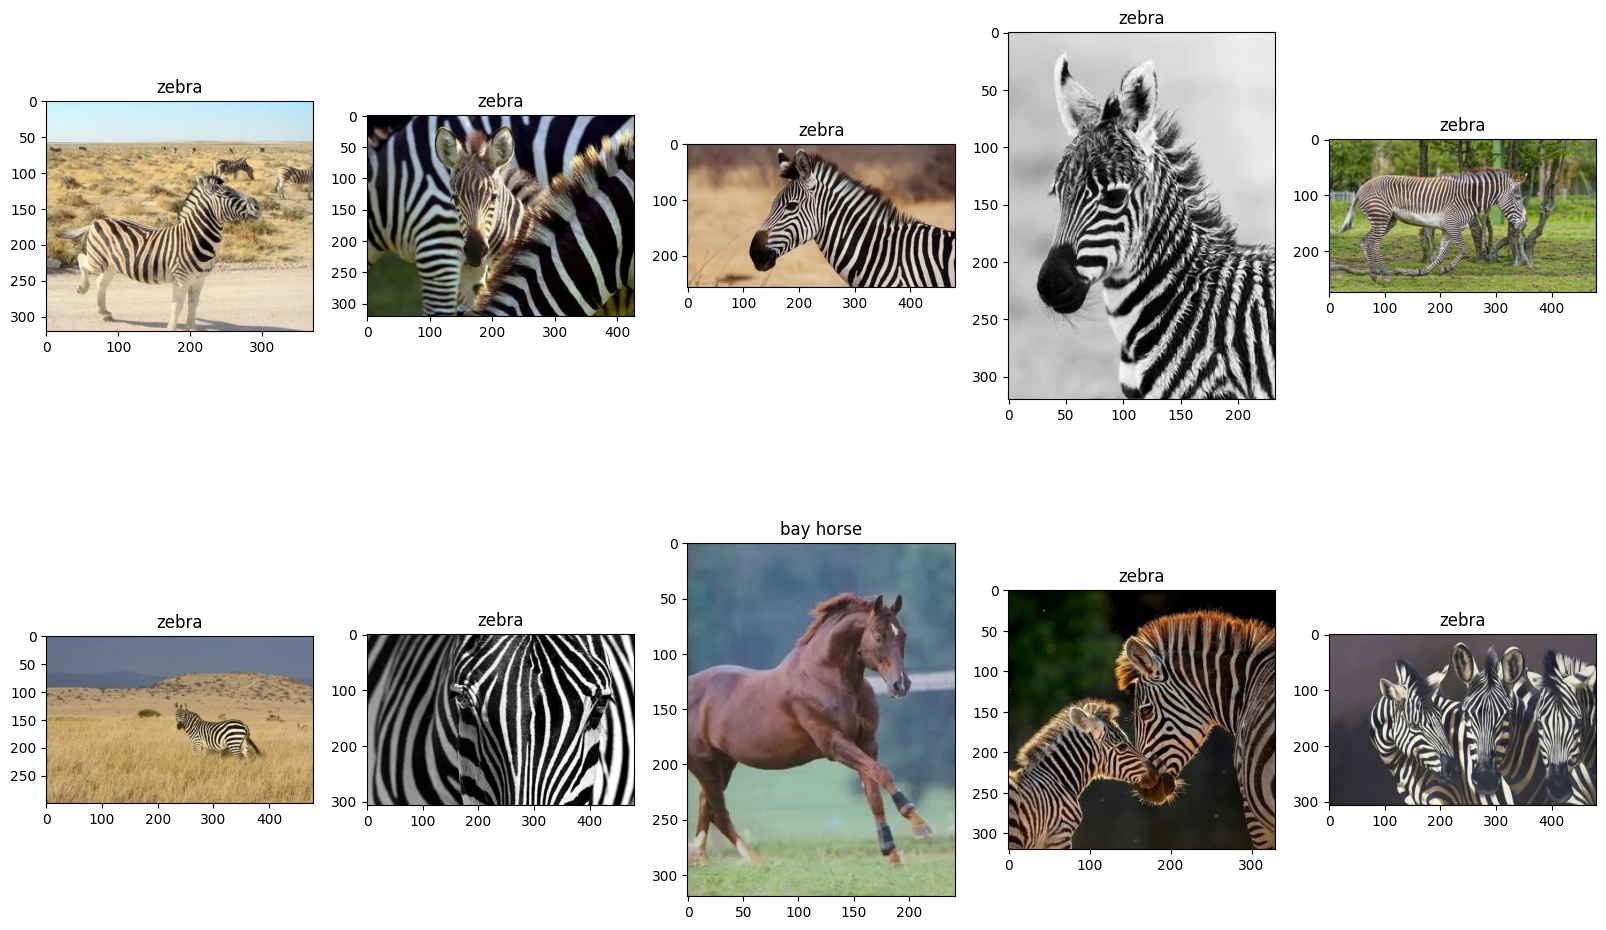

In [22]:
class_ = {0: 'zebra', 1: 'bay horse'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)

Task 9-10, saving and loading

In [23]:
torch.save(model.state_dict(), 'ConvNetModel.pth')

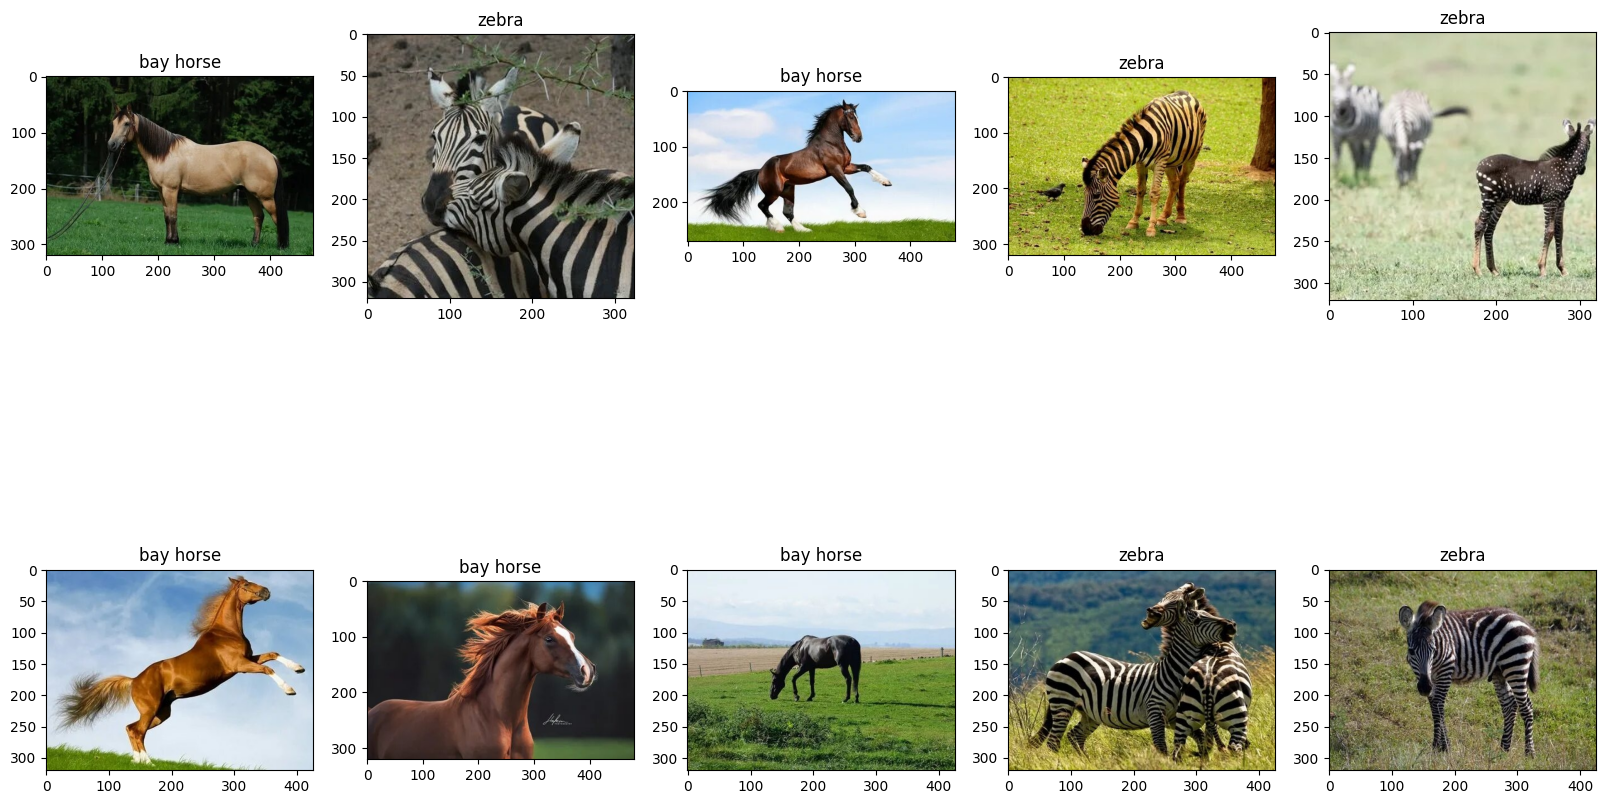

In [24]:
loaded_model = ConvNet().to(device)
loaded_model.load_state_dict(torch.load('ConvNetModel.pth'))
loaded_model.eval()

bay_horse = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = loaded_model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        bay_horse += list(zip(labels, preds_list))
        
idx = list(map(lambda x: x[0],bay_horse))
prob = list(map(lambda x: x[1],bay_horse))

submission = pd.DataFrame({'id':idx,'label':prob})

class_ = {0: 'zebra', 1: 'bay horse'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)